In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction

Web scraping refers to the extraction of the data from the web-sites and converting it into more useful format. For example, you might extract an article from the web-site and push it into csv file. Although web scraping can be done manually, in most cases, you might be better off using an automated tool.

In this notebook, we will extract articles from geeks for geeks on the topic Python.

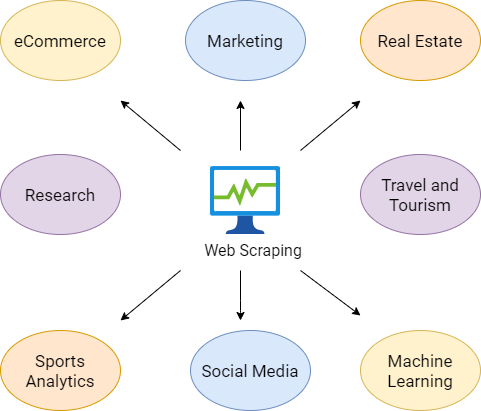

# Dependencies
bs4,urllib and requests - for web-scrapping

pandas - for storing data

lxml - for "reading" site


nltk, re and string - for text preprocessing

matplotlib,pyplot - for vizualisation

In [ ]:
pip install lxml

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import lxml
from bs4 import Comment 
import string
from sklearn.metrics import r2_score
from sklearn.naive_bayes import MultinomialNB
import re
import urllib
import seaborn as sns
import matplotlib.pyplot as plt

# Web-scrapping

**We are going to take data from the geeks for geeks website, so let's create a link with our datasource. In this example we will extract python articles**

In [ ]:
python_articles = "https://www.geeksforgeeks.org/category/language/python/page/"

**Let's get the python articles**

There are many pages that contain python articles, so we'll have to iterate over them

In [ ]:
def get_links(name,pages):
    links = []
    for i in range(1,pages+1):
        py_page = requests.get(name+'/'+str(i))
        py_soup = BeautifulSoup(py_page.content, 'lxml')
        jobs = py_soup.find_all("div",class_='content')
        links.extend(jobs)
        print(i)
    return links

**In this notebook, we will work on the small data (only 10 pages), because our goal here is not to create a dataset, but to learn how to extract data from the websites. If our goal was to collect some data for machine learning, we would've read more pages**

In [ ]:
links = get_links(python_articles,10)

You may wonder where I get this  ```jobs = py_soup.find_all("div",class_='content')```. string. I just opened one of the pages in the catalogue, right-clicked one of the articles, chose to show the code of the element and saw the following code (the code of the element is automatically highlited). The object I needed was situated inside the  div type, class container.

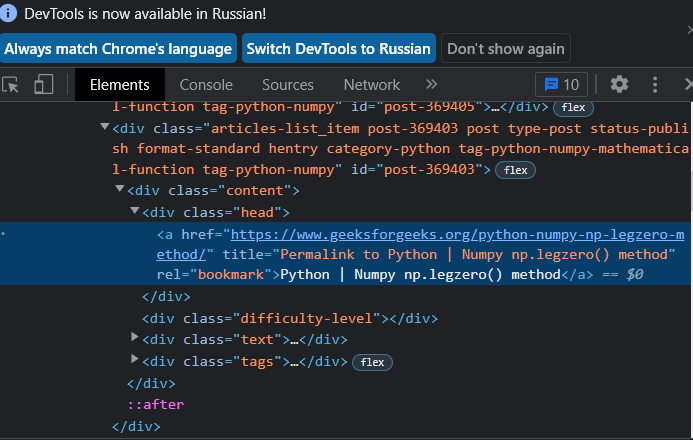

In [ ]:
print(links[0])

**Is this what we needed? No, let's extract the links from these pieces of the html code**

In [ ]:
def get_urls(links):
    urls = []
    for link in links:
        a = link.find("a")
        if a!=None:
            urls.append(a['href'])
        else:
            urls.append(None)
    return urls

In [ ]:
urls = get_urls(links)
#how many non-na articles there are
print('Links found',len([el for el in urls if el!=None]))
print('Overall length',len(urls))
urls

Where did I get the .fina("a") and ['href']? The answer is on the picture above.

**And now comes the most important part, getting the texts of the articles**

In [ ]:
def tag_visible(element):
    if element.parent.name in [
            'style', 'script', 'head', 'title', 'meta', '[document]'
    ]:
        return False
    if isinstance(element, Comment):
        return False
    return True


def text_from_html(body):
    body = urllib.request.urlopen(body).read()
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)
    return u" ".join(t.strip() for t in visible_texts)


#html = urllib.request.urlopen('https://yahoo.com').read()
#print(text_from_html(html))

In [ ]:
texts = []
for (i,url) in enumerate(urls):
    if url!=None:
        text = text_from_html(url)
        #print("TEXT\n\n\n",url)
        #print(text)
        texts.append(text)
    else:
        texts.append(None)
    if i%10==0:
        print(i)
    
df = pd.DataFrame()
df['text_unprocessed'] = texts
df['url'] = urls
df['class'] = 'python'

In [ ]:
df

# Text preprocessing (cleaning the mess)

In [ ]:
df.text_unprocessed[0]

In [ ]:
df.text_unprocessed[1]

**The data is really messy, because we have not only the article text, but the other elements of the interface like the advertisment of the other articles published on the site, courses information etc. Let's make the data cleaner**

In [ ]:
same = 0
for i in range(0,len(df.text_unprocessed[0])):
    is_same = True
    for j in range(180):
        if df.text_unprocessed[j]!=None and df.text_unprocessed[j+1]!=None:
            #print(j)
            if df.text_unprocessed[j][:i] != df.text_unprocessed[j+1][:i]:
                same = i
                is_same = False
                break
    if not is_same:
        break
            

In [ ]:
print('the same content at the beginning',same)
print('the length of the first article',len(df.text_unprocessed[0]))


**We can see that the extracted texts have a lot of common text in the beginning. Is there a similar situation, but in the end of the texts?**

In [ ]:
same2 = 0
for i in range(0,len(df.text_unprocessed[0])):
    is_same = True
    for j in range(180):
        if df.text_unprocessed[j]!=None and df.text_unprocessed[j+1]!=None:
            #print(j)
            if df.text_unprocessed[j][::-1][:i] != df.text_unprocessed[j+1][::-1][:i]:
                same2 = i
                is_same = False
                break
    if not is_same:
        break
            

In [ ]:
print('the same amount of text the articles have in the end is',same2)

**Let's see how the first article look without this extra text**

In [ ]:
df.text_unprocessed[0][3747:(12161-850)]

**It is still very messy, but a little bit better**

**Let's apply this kind of preprocessing to all the articles in the dataset**

In [ ]:
import math
def process(x):
    if x==None:
        return None
    else:
        #print(x)
        return x[3747:(len(text)-849)]
df['text'] = df['text_unprocessed'].apply(process)
#the second articlle now
#df.url[1]
df['text'][1]

**We can see that in the end of the articles there is some mess data split by |. Let's see how many of | there are in the different texts**

In [ ]:
count_sticks = df.text.apply(lambda x: x.count("|") if x!=None else None)
print(list(count_sticks))

**Let's plot the distribution of the count of the sticks**

In [ ]:
sns.histplot(count_sticks).set_title("The count of the | in the text")
print('mean sticks',count_sticks.mean())
print('min sticks',count_sticks.min())
print('median sticks',count_sticks.median())
print('mode sticks',count_sticks.mode())

**The most of the texts have between 10 and 20 sticks, but many of them have from 0 to 2 "|". We have to take that into account. What is more, we must understand that not every "|" is necesarilly a part of this non-article content. "|" can be a part of the article and contain useful information, so I don't think we should drop all the "|" with content between them. I think we should explore our texts more and may be we will come up with a better idea**

In [ ]:
for i,el in enumerate(df.text[0]):
    if el=="|":
        print(i)
df.text[0][1877:6122]

In [ ]:
for i,el in enumerate(df.text[1]):
    if el=="|":
        print(i)
df.text[1][1877:6226]

In [ ]:
for i,el in enumerate(df.text[2]):
    if el=="|":
        print(i)
df.text[0][1877:6122]

**Now I wonder how many of the articles in the dataset have a stick in the position 1877. If so, this can be the clue. (In this case 1877 is the last stick in the beginning)**

In [ ]:
no = 0
yes = 0
for el in df.text:
    if el!=None:
        if el[1877]!='|':
            no+=1
        else:
            yes+=1
print(yes,no)

In [ ]:
def drop_stick(x):
    if x==None:
        return None
    if x[1877]=="|":
        return x[1878:]
    else:
        return x
df['text'] = df['text'].apply(drop_stick)
df['text']

In [ ]:
df['text'][2]

**There is an interesting detail: many of the extracted articles contain "Last Updated: /some_date/" part in the beginning. Let's see if this is True for all of them**

In [ ]:
last_upd = []
count_true = 0
count_false = 0
#Last Updated :  21 Apr, 2022
regexp = re.compile(r'Last Updated :  [0-9]{1,2} [a-zA-Z]{3,4}, [0-9]{4}')
for el in df.text:
    if el!=None:
        if not re.search(regexp,el):
            count_false+=1
        else:
            count_true+=1
            last_upd.append(el.find("Last Updated"))
print('contains regex:',count_true,'does not contain regex:',count_false)

**Hooray! I was right! We can safely drop all the text data until the end of the "Last Updated :/date/" regex!**

In [ ]:
def drop_not_needed(text):
    global regexp
    if text!=None:
        #print(re.search(regexp,text))
        index = re.search(regexp,text).end()+1
        return text[index:]
    return None

df['text_processed'] = df['text'].apply(drop_not_needed)

**Let's see the texts now**

In [ ]:
df['text_processed']

**It's much better! Now let's look at the ends of the articles and try to find if they have something in common**

In [ ]:
df.text_processed[0]

In [ ]:
df.text_processed[1]

In [ ]:
df.text_processed[2]

**In the first text, I found an interesting "Recommended Articles Page : "  substring. It seems like a part of every Geeks for geeks article web-page. Does it exist in all the texts in the dataset?**

In [ ]:
def contains_rec(text):
    if text!=None:
        if 'Recommended Articles Page :' in text:
            return True
        else:
            return False
    return None

def where_rec_occurs(text):
    if text!=None:
        if 'Recommended Articles Page :' in text:
            #print(re.finditer(r'Recommended Articles Page :',text)[-1])
            return text.rfind('Recommended Articles Page :') 
   #     list(re.finditer(r'Recommended Articles Page :',text))[-1].start()
        else:
            return None
    return None

contains = df.text_processed.apply(contains_rec)
indexes = df.text_processed.apply(where_rec_occurs)
print(contains.value_counts())
print("Index of the last occurence of 'Recommended articles' in each text",list(indexes))

**Let's plot the distribution of the last occurence indexes of the 'Recommended articles' and the distribution of the difference between the indexes of the last occurence and the lengths of the articles**

In [ ]:
sns.histplot(indexes).set_title('Length of the text without Recommended articles part')
plt.show()
df['len'] = df['text_processed'].apply(lambda x:len(x) if x!=None else None)
sns.histplot(df['len']-indexes).set_title('Length of the Recommended articles part')

**The diagrams above seems to be quite realistic: it is possible for a programming article to have a length betwene 2000 and 9000 symbols and it is possible for the "Recommended" articles part to have a length from 500 to 4000 symbols**

In [ ]:
def cut_ends(text):
    if text==None:
        return None
    elif 'Recommended Articles Page :' in text:
        return text[:text.rfind('Recommended Articles Page :')]
    else:
        return text
df['text_articles'] = df['text_processed'].apply(cut_ends)
df['text_articles']

In [ ]:
df['text_articles'][0]

In [ ]:
df['text_articles'][1]

In [ ]:
df['text_articles'][2]

# Conclusion:

1) Web-parsing is not easy, because different websites have different structures, there is no universal formula that would alway work

2) There is no universal formula for text preprocessing: every set of texts is unique

3) There is still a lot of work to do with these texts. For example to drop all these extra symbols like "0xFF"